## MLP 

MLP stands for Multi Layer Perceptron.

This notebook contains implementation of one of the first successful neural net implementation for natural language processing. [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

This implementation is only educational, for my better understanding of basics of NN for NLP and the ability of reading and implementing raw deep learning papers.

In [1]:
import torch

In [2]:
with open("../bigram/polish_names.txt", "r") as file:
    names = [name.rstrip("\n") for name in file.readlines()]
print(f"Number of names: {len(names)}")

Number of names: 54548


In [3]:
def isascii(string: str):
    for ch in string:
        if ord(ch) not in range(97, 123): return False
    return True

filtered_names = [name for name in filter(lambda item: isascii(item), names)]
print(f"Number of names without words containing nonascii characters {len(filtered_names)}.")

Number of names without words containing nonascii characters 46168.


In [4]:
for name in filtered_names[1:2]:
    word = list("." + name + ".")
    print(word)

['.', 'k', 'r', 'z', 'y', 's', 'z', 't', 'o', 'f', '.']


### Create mapping C

For the mlp model we need to have mapping C that will represent each letter i from the training set into distributed feature vector R^m.

In practice mapping C will be matrix |V| x m, where V is a vocabulary and |V| is size of that vocabulary.

The number m is a user defined number of columns for each letter in the vocabulary.

In [5]:
filtered_names.append(".")
V = list(sorted(set(''.join(filtered_names))))
print(f"|V| = {len(V)}\n V --> {V}")

|V| = 27
 V --> ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
#character to int
stoi = {char:num for num, char in enumerate(V)}

#int to character
itos = {num:char for char, num in stoi.items()}

assert stoi['b'] == 2
assert itos[2] == 'b'

In [7]:
C = torch.randn((27, 10), dtype=torch.float, requires_grad=True, device="cuda")
print(f"Mapping C is ---> {C.shape[0]} x {C.shape[1]}")

Mapping C is ---> 27 x 10


Meaning that each letter in our dataset is repesented by 3 values.

Paper also requires certain number of previous inputs, proposed number in the paper is 3, and that's how many we are going to use.

In [8]:
import random

num_previous = 4
X, Y = [], []
random.shuffle(filtered_names)

for name in filtered_names:

    #initialize list of ['.','.','.'] for the first character.
    tmp = [0] * num_previous
    for char in name + '.':
        X.append(tmp)
        Y.append(stoi[char])
        # print(''.join(itos[ch] for ch in tmp), "-->", char)
        tmp = tmp[1:] + [stoi[char]]

X = torch.tensor(X, device='cuda')
Y = torch.tensor(Y, device='cuda')

# train, validation, test split
train = int(len(X) * 0.8)
test = int(len(X) * 0.9)

X_train, Y_train = X[:train], Y[:train]
X_val, Y_val = X[train:test], Y[train:test]
X_test, Y_test = X[test:], Y[test:]

assert X.shape[0] == (X_train.shape[0] + X_val.shape[0] + X_test.shape[0])
assert Y.shape[0] == (Y_train.shape[0] + Y_val.shape[0] + Y_test.shape[0])

### Create hidden layer of NN

In [9]:
#embedding for letter and C
embedding = C[X]
embedding.shape

torch.Size([342781, 4, 10])

Here as an example, we are taking element at index 1 from X which is: ..p --> i, and the embedding C[X][1, 2] is representing this selection

In [10]:
X[1, 2].item(), C[X][1, 2]

(0,
 tensor([-0.6015,  1.1577, -0.1318, -0.5271,  1.8858, -1.6796,  0.6778,  0.7061,
         -1.1263,  1.3492], device='cuda:0', grad_fn=<SelectBackward0>))

In [11]:
C[X][1, 2] == C[stoi["p"]]

tensor([False, False, False, False, False, False, False, False, False, False],
       device='cuda:0')

As we can see the embedding work as it should, we are looking for letter 'p' in the embedding and it gives the same result as directly referencing matrix C

In [12]:
embedding.shape, X.shape

(torch.Size([342781, 4, 10]), torch.Size([342781, 4]))

Now last thing to do is to flatten the dimmensions of embedding to 2D array so we can do mathematical operations efficiently.

To do that in place without re-creating embedding matrix from the scratch we are going to use view() function from PyTorch API.

In [13]:
embedding.view((X.shape[0], C.shape[1] * num_previous)).shape

torch.Size([342781, 40])

In [14]:
#first number is number of columns in embedding matrix and second is number of neurons in our hidden layer.
W1 = torch.randn((C.shape[1] * num_previous, 200), requires_grad=True, device='cuda')
b1 = torch.randn(200, requires_grad=True, device="cuda")
W2 = torch.randn((200, len(V)), requires_grad=True, device='cuda')
b2 = torch.randn(len(V), requires_grad=True, device='cuda')

#### Forward pass

In [15]:
import torch.nn.functional as F
from alive_progress import alive_bar

epoch_counter = 1
params = [W1, b1, W2, b2, C]
losses = []

In [45]:
epochs = 20000
learning_rate = 0.1

with alive_bar(epochs, dual_line=True, title="Learning") as bar:
    for epoch in range(epochs):
        #create minibatch of data, using size of 512 since it's running on GTX 1080Ti with 12GB of VRAM
        batch = torch.randint(0, X_train.shape[0], (512,))
        
        #perform operations on selected rows to the batch
        embedding = C[X_train[batch]]
    
        #calculate activation for the hidden layer
        activation = torch.tanh(embedding.view(-1, num_previous * C.shape[1]) @ W1 + b1)
    
        #compute loss
        loss = F.cross_entropy((activation @ W2 + b2), Y_train[batch])
        bar.text = f"Loss in epoch {epoch_counter} ---> {loss.item()}"
    
        #append flattened loss by log10, so it will look better on the plot
        losses.append(loss.log10().item())
    
        # print(f"Loss in epoch {epoch_counter} ---> {loss.item()}")
        epoch_counter += 1
    
        #Clear previous gradient and perform backward pass
        for p in params:
            p.grad = None
        loss.backward()
    
        for p in params:
            p.data += -learning_rate * p.grad
        bar()
    
val_emb = C[X_val]
val_act = torch.tanh(val_emb.view(-1, C.shape[1] * num_previous) @ W1 + b1)
print(f"Loss on validation dataset in {epoch_counter} epochs ---> {F.cross_entropy((val_act @ W2 + b2), Y_val).item()}")

Learning |████████████████████████████████████████| 20000/20000 [100%] in 28.1s (710.80/s) 
Loss on validation dataset in 240001 epochs ---> 2.27984881401062


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

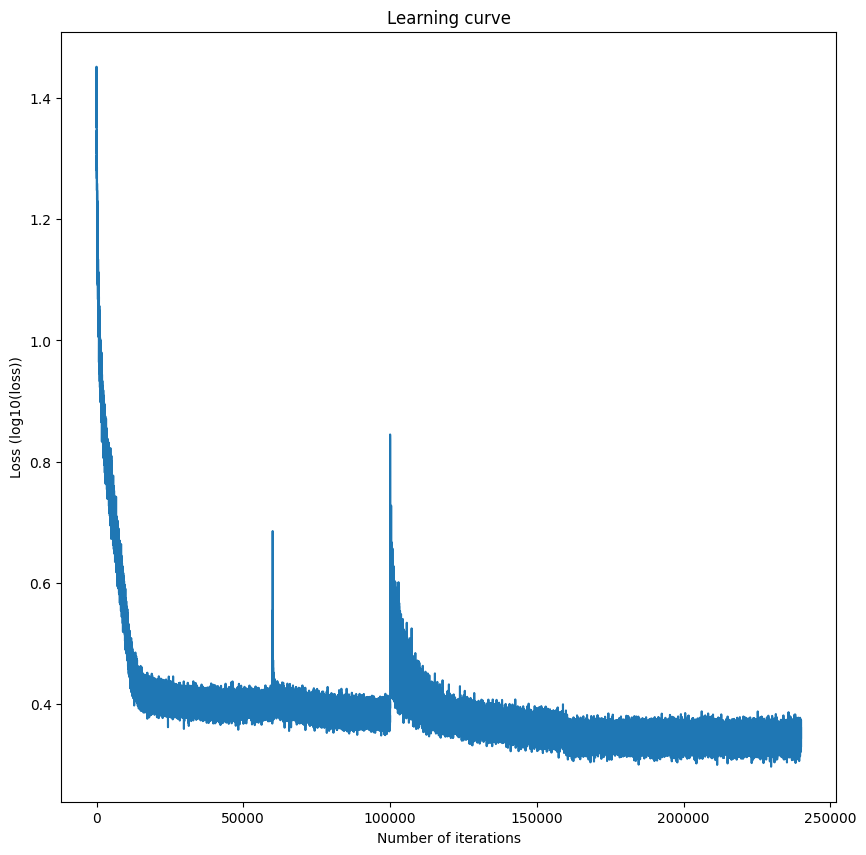

In [46]:
plt.figure(figsize=(10,10))
plt.title("Learning curve")
plt.xlabel("Number of iterations")
plt.ylabel("Loss (log10(loss))")
plt.plot(range(epoch_counter-1), losses)

In [47]:
test_emb = C[X_test]
test_act = torch.tanh(test_emb.view(-1, C.shape[1] * num_previous) @ W1 + b1)
print(f"Loss on test dataset in {epoch_counter} epochs ---> {F.cross_entropy((test_act @ W2 + b2), Y_test).item()}")

Loss on test dataset in 240001 epochs ---> 2.263584852218628


In [51]:
for _ in range(15):
    context = [0] * num_previous
    example = []
    while True:
        emb = C[torch.tensor([context])]
        act = torch.tanh(emb.view(1, -1) @ W1 + b1)
        prob = F.softmax(act @ W2 + b2, dim=1)
        sample = torch.multinomial(prob, 1, replacement=True).item()
        example.append(itos[sample])
        context = context[1:] + [sample]
        if sample == 0:
            break
    print(''.join(example))

ashusumantako.
newek.
imek.
soyn.
batio.
tron.
zyaziba.
amnika.
abdoneka.
coli.
klar.
gantoy.
frorita.
emka.
sarwan.


As we can see some of the results are pretty close to actual names, or at least sound "name-ish" if you say them out loud.

## PyTorch-ish apporach